This project refers to ideas and codes of follwing websites:

http://krasserm.github.io/2018/04/07/latent-space-optimization/

https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb

###1. Data preparation
*A. Load Data*

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


###2. Model construction 

In [0]:
# Dimensions of MNIST images  
image_shape = (28, 28, 1)

# Dimension of latent space
latent_dim = 1

# Mini-batch size for training
batch_size = 128

def create_encoder():
    '''
    Creates a convolutional encoder model for MNIST images.
    
    - Input for the created model are MNIST images. 
    - Output of the created model are the sufficient statistics
      of the variational distriution q(t|x;phi), mean and log 
      variance. 
    '''
    encoder_iput = layers.Input(shape=image_shape)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_iput)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    t_mean = layers.Dense(latent_dim)(x)
    t_log_var = layers.Dense(latent_dim)(x)

    return Model(encoder_iput, [t_mean, t_log_var], name='encoder')

def create_decoder():
    '''
    Creates a (de-)convolutional decoder model for MNIST images.
    
    - Input for the created model are latent vectors t.
    - Output of the model are images of shape (28, 28, 1) where
      the value of each pixel is the probability of being white.
    '''
    decoder_input = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(12544, activation='relu')(decoder_input)
    x = layers.Reshape((14, 14, 64))(x)
    x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
    
    return Model(decoder_input, x, name='decoder')

In [0]:
def sample(args):
    '''
    Draws samples from a standard normal and scales the samples with
    standard deviation of the variational distribution and shifts them
    by the mean.
    
    Args:
        args: sufficient statistics of the variational distribution.
        
    Returns:
        Samples from the variational distribution.
    '''
    t_mean, t_log_var = args
    t_sigma = K.sqrt(K.exp(t_log_var))
    epsilon = K.random_normal(shape=K.shape(t_mean), mean=0., stddev=1.)
    return t_mean + t_sigma * epsilon

def create_sampler():
    '''
    Creates a sampling layer.
    '''
    return layers.Lambda(sample, name='sampler')

In [4]:
encoder = create_encoder()
decoder = create_decoder()
sampler = create_sampler()

x = layers.Input(shape=image_shape)
t_mean, t_log_var = encoder(x)
t = sampler([t_mean, t_log_var])
t_decoded = decoder(t)

vae = Model(x, t_decoded, name='vae')

In [0]:
def neg_variational_lower_bound(x, t_decoded):
    '''
    Negative variational lower bound used as loss function
    for training the variational auto-encoder.
    
    Args:
        x: input images
        t_decoded: reconstructed images
    '''
    # Reconstruction loss
    rc_loss = K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1)

    # Regularization term (KL divergence)
    kl_loss = -0.5 * K.sum(1 + t_log_var \
                             - K.square(t_mean) \
                             - K.exp(t_log_var), axis=-1)
    
    # Average over mini-batch
    return K.mean(rc_loss + kl_loss)

In [6]:
# MNIST training and validation data
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# Compile variational auto-encoder model
vae.compile(optimizer='rmsprop', loss=neg_variational_lower_bound)

vae.summary()

11493376/11490434 [==============================] - 2s 0us/step


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 1), (None, 1 494178      input_3[0][0]                    
__________________________________________________________________________________________________
sampler (Lambda)                (None, 1)            0           encoder[1][0]                    
                                                                 encoder[1][1]                    
__________________________________

In [7]:
# Train variational auto-encoder with MNIST images
vae.fit(x=x_train, 
         y=x_train,
         epochs=10,
         shuffle=True,
         batch_size=batch_size,
         validation_data=(x_test, x_test), verbose=2)




Train on 60000 samples, validate on 10000 samples
Epoch 1/10





 - 26s - loss: 196.1465 - val_loss: 183.8128
Epoch 2/10
 - 18s - loss: 181.9785 - val_loss: 178.3423
Epoch 3/10
 - 18s - loss: 176.0166 - val_loss: 171.4756
Epoch 4/10
 - 18s - loss: 171.8832 - val_loss: 168.3549
Epoch 5/10
 - 18s - loss: 169.5091 - val_loss: 166.6321
Epoch 6/10
 - 18s - loss: 167.5968 - val_loss: 166.7321
Epoch 7/10
 - 18s - loss: 166.2047 - val_loss: 165.5551
Epoch 8/10
 - 18s - loss: 165.0671 - val_loss: 162.8140
Epoch 9/10
 - 18s - loss: 164.1232 - val_loss: 163.7996
Epoch 10/10
 - 18s - loss: 163.4604 - val_loss: 163.3236


###3. Results

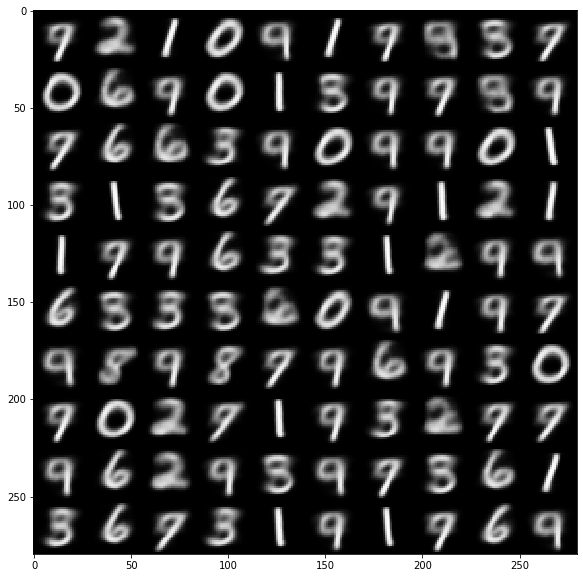

In [8]:
test100 = x_test[0:100]
output100 = vae.predict(test100,batch_size=batch_size)

# Display a 2D manifold of the digits
n = 10  # figure with 10x10 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
  for j in range(n):
    index = i*10+j*1
    digit = output100[index].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()  

***Similarity***

Use MSE & SSIM as two measurements of similarity.

Reference: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

![image.png](https://www.pyimagesearch.com/wp-content/uploads/2014/06/compare_mse.png)

![image.png](https://www.pyimagesearch.com/wp-content/uploads/2014/06/compare_ssim.png)

In [0]:
# import the necessary packages
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [0]:
def mse(imageA, imageB):
  # the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  err /= float(imageA.shape[0] * imageA.shape[1])
  # return the MSE, the lower the error, the more "similar"
  # the two images are
  return err
 
def compare_images(imageA, imageB):
	# compute the mean squared error and structural similarity
	# index for the images
  m = mse(imageA, imageB)
  s = measure.compare_ssim(imageA, imageB)
  return m,s

In [11]:
mse_list=[]
ssim_list=[]
for x in range(100):
  m,s = compare_images(test100[x][:,:,0],output100[x][:,:,0])
  mse_list.append(m)
  ssim_list.append(s)
avg_mse=np.mean(mse_list)
avg_ssim=np.mean(ssim_list)
print(avg_mse,avg_ssim)

0.04552462518840038 0.4898288534627827
